In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torchvision.utils as vutils
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
import os
from torch.utils.checkpoint import checkpoint
from torch.nn.utils import spectral_norm
#for loading data
import h5py
import torch.utils.data as tud

In [0]:
#check if GPU is working and set device
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 


device(type='cuda')

In [0]:
document = os.path.join(os.path.expanduser("~"), "/content/drive/My Drive/Colab Notebooks/LLD_32")
loadPath_2x = os.path.join(document, "icon_2x.pt")
loadPath_4x = os.path.join(document, "icon_4x.pt")

In [0]:
# Batch size during training
batch_size = 64
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32
# Number of training epochs
num_epochs =50
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# the number of clusters is the length of condition vector
nl = 100
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [0]:
icons32_4x=torch.load(loadPath_4x)
icons32_2x=torch.load(loadPath_2x)
#combine for training the entire dataset 
icon_combined =  torch.cat((icons32_2x,icons32_4x), dim=0)
icons32_4x = None
icons32_2x = None
LLDloader = torch.utils.data.DataLoader(icon_combined, shuffle=True, batch_size=batch_size)

##Weight Initialization & Plot Function


In [0]:
#plot 64(8*8) images in one plot
def showImages(imgs):
    imgs = imgs/2 + 0.5
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), interpolation='bicubic')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [0]:
#initialize weights 'CONV' and 'Batch' by normal distribution with(mean,std) 
def weights_init(m):
    torch.manual_seed(42787)
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1., 0.02)
        m.bias.data.fill_(0.)


In [0]:
def saveImages(imgs,path):
    imgs = imgs/2 + 0.5
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.cpu()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), interpolation='bicubic')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(path)
    plt.show()

In [0]:

def onehot(cond,b_size=64):
  m = F.one_hot(torch.arange(nl))
  return m[cond].view(b_size,nl,1,1).float()
  

##DCGAN

In [0]:
#generator
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False), 
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ngf ),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*1) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(nc),
            nn.Tanh()
            # state size. (nc) x 32 x 32
            )
        
            # forward method
    def forward(self, input):

        return self.main(input)

In [0]:
#discriminator   
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),

            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

            # forward method
    def forward(self, input):
        return self.main(input)

In [0]:
#save the model
G=generator().to(device)
D=discriminator().to(device)

criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = opt.Adam(D.parameters(), lr=0.00042, betas=(0.9, 0.999))
optimizerG = opt.Adam(G.parameters(), lr=0.000065, betas=(0.9, 0.999))

#fixed size of noise for plotting manually or testing 
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 



In [0]:
#with label smoothing and noise, without spectral norm

Load_G_weightsPath = os.path.join(document,          "G_G4C_D4C_2x_nz100gf64_Glr000065_Dlr00042_L88_05")
Load_D_weightsPath = os.path.join(document,          "D_G4C_D4C_2x_nz100gf64_Glr000065_Dlr00042_L88_05")

stateG_icon32x32=torch.load(Load_G_weightsPath)
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
epoch_last = stateG_icon32x32['epoch']
G_losses = stateG_icon32x32["G_losses"]



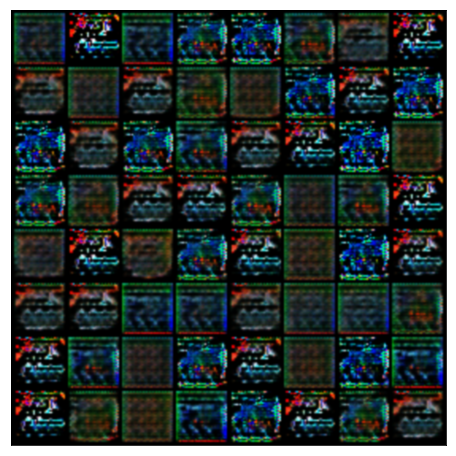

In [0]:
#manully plot
samples = G(fixed_noise).detach()
showImages(samples[0:64])

##DCGAN - spectral norm


In [0]:
#generator
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            spectral_norm(nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False)), 
  
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 4 x 4
            spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)), 
 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 8 x 8
            spectral_norm(nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False)), 
  
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*1) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(nc),
            nn.Tanh()
            # state size. (nc) x 32 x 32
            )
        
            # forward method
    def forward(self, input):

        return self.main(input)

In [0]:
#discriminator   
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
   
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),

            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),  
            nn.Sigmoid()
        )

            # forward method
    def forward(self, input):
        return self.main(input)

In [0]:
#save the model
G=generator().to(device)
D=discriminator().to(device)

#set the loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = opt.Adam(D.parameters(), lr=0.00042, betas=(0.9, 0.999))
optimizerG = opt.Adam(G.parameters(), lr=0.000065, betas=(0.9, 0.999))

#fixed size of noise for plotting manually or testing 
torch.manual_seed(5567)
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 



In [0]:
#with spectral norm but without noise 
Load_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4C_2x_nz100gf64_Glr000065_Dlr00042")
Load_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4C_2x_nz100gf64_Glr000065_Dlr00042")

stateG_icon32x32=torch.load(Load_G_weightsPath)
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
epoch_last = stateG_icon32x32['epoch']
G_losses = stateG_icon32x32["G_losses"]


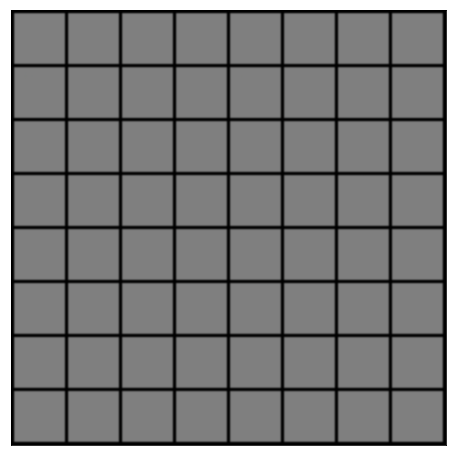

In [0]:
#manully plot
samples = G(fixed_noise).detach()
showImages(samples[0:64])

In [0]:

Load_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4CNoise_2x_nz100gf64_Glr000065_Dlr00042_L88_05")
Load_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4CNoise_2x_nz100gf64_Glr000065_Dlr00042_L88_05")

stateG_icon32x32=torch.load(Load_G_weightsPath)
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
epoch_last = stateG_icon32x32['epoch']
G_losses = stateG_icon32x32["G_losses"]

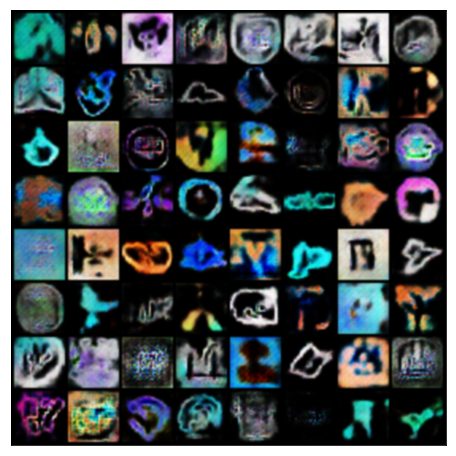

In [0]:
#manully plot
samples = G(fixed_noise).detach()
showImages(samples[0:64])

##Autoencoder 

In [0]:
#hyper parameters for autoencoder 
#number of feature maps extract by autoencoder 
nf_auto = 4
nc = 3
#autoencoder to encode the input image for clustering 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #input 32x32
            nn.Conv2d(nc, nf_auto, 4, 2, 1), 
            nn.ReLU(True),
            #state size 16x16
            nn.Conv2d(nf_auto, nf_auto*2 , 4, 2, 1),  
            nn.ReLU(True),
            #state size 8x8
            nn.Conv2d(nf_auto*2, nf_auto*2 , 4, 2, 1),  
            nn.ReLU(True),
            #output 4*4
        )
        
        self.decoder = nn.Sequential(
            #input is 4x4
            nn.ConvTranspose2d(nf_auto*2, nf_auto*2, 4, 2, 1),  
            nn.ReLU(True),
            #state size 8x8
            nn.ConvTranspose2d(nf_auto*2, nf_auto, 4, 2, 1),  
            nn.ReLU(True),
            #state size 16x16
            nn.ConvTranspose2d(nf_auto, nc, 4, 2, 1),  
            nn.Tanh()
            #output 16x16
        )
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
      
#set parameters for autoencoder 
autoencoder = Autoencoder()
autoencoder.cuda()
criterion_auto = nn.MSELoss()
optimizer_auto = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, betas=(0.85, 0.999),eps = 1e-5)

In [0]:
AEweights_Path = os.path.join(document, "AE_weights_3C_4")
Autoencoder_weights=torch.load(AEweights_Path)
autoencoder.load_state_dict(Autoencoder_weights['state_dict'])
optimizer_auto.load_state_dict(Autoencoder_weights['optimizer'])

Original dataset


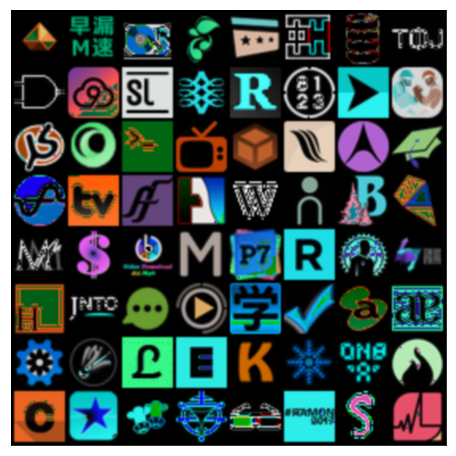

Result from Autoencoder


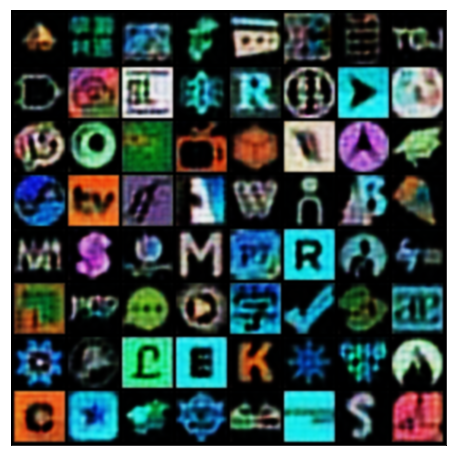

In [0]:
check_decoder = autoencoder(icon_combined[0:64].to(device))[1]
check_decoder.shape
print("Original dataset")
showImages(icon_combined[0:64])
print("Result from Autoencoder")
showImages(check_decoder.detach())

## Result of Kmeans Clustering 


In [0]:
Kmeans_savePath =  os.path.join(document, "SSEKmeans")
sse = {}
index = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10, random_state = 4503).fit(b)
    #b["clusters"] = kmeans.labels_

    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    index[k] = kmeans.labels_
font = {
        'color':  'blue',
     
        'size': 16,
        }



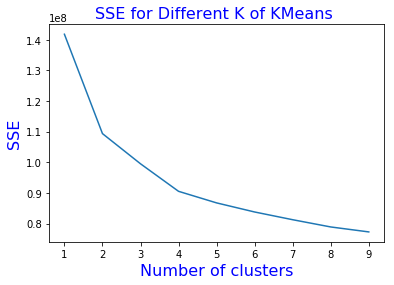

In [0]:
font = {
        'color':  'blue',
     
        'size': 16,
        }

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title('SSE for Different K of KMeans ',fontdict = font)
plt.xlabel("Number of clusters",fontdict = font)
plt.ylabel("SSE",fontdict = font)
plt.savefig(Kmeans_savePath)
plt.show()

In [0]:

Load_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4CNoise_c0c3c2c1_nz100gf64_Glr000065_Dlr00042_L88_05")
Load_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4CNoise_c0c3c2c1_nz100gf64_Glr000065_Dlr00042_L88_05")

stateG_icon32x32=torch.load(Load_G_weightsPath)
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
epoch_last = stateG_icon32x32['epoch']
G_losses = stateG_icon32x32["G_losses"]

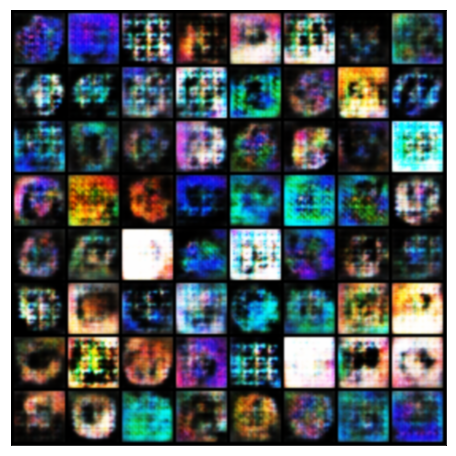

In [0]:
#manully plot
samples = G(fixed_noise).detach()
showImages(samples[0:64])

##GMM clustering 

In [0]:
GMM_path = os.path.join(document,'GMM_clusterIdx_80_100')
GMM_idx = torch.load(GMM_path)


In [0]:
icon_combined_cond = TensorDataset(icon_combined, torch.LongTensor(GMM_idx[100]))

In [0]:
LLDloader_cond = torch.utils.data.DataLoader(icon_combined_cond, shuffle=True, batch_size=batch_size)

In [0]:
dataiter = iter(LLDloader_cond)
images, labels = dataiter.next()

In [0]:
nl = 100
img_size = 32
filled = torch.zeros(nl*nl*img_size*img_size)
filled=filled.view(100, 100, 32, 32)
for i in range(100):
    filled[i, i, :, :] = 1

##Conditional DCGAN

In [0]:
#generator
class generator(nn.Module):
    # initializers
    def __init__(self):
        super(generator, self).__init__()
        
        
        # cat them together
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            spectral_norm(nn.ConvTranspose2d( nz+nl, ngf*4 , 4, 1, 0, bias=False)),   
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 4 x 4
            spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),  
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 8 x 8
            spectral_norm(nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False)),   
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ngf*1) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(nc),
            nn.Tanh()
            # state size. (nc) x 32 x 32
            )
            
            # forward method
    def forward(self, input, cond):
        
        z = torch.cat([input, cond], 1)

        
        return self.main(z)

In [0]:
#discriminator   
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        
        
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(nc+nl, ndf, 4, 2, 1, bias=False)), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            spectral_norm(nn.Conv2d(ndf, ndf *2, 4, 2, 1, bias=False)),
   
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),

            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            spectral_norm(nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)),  
            nn.Sigmoid()
            )

            # forward method
    def forward(self, input, cond):
                
        img = torch.cat([input, cond], 1)
                
        return self.main(img)

In [0]:
#save the model
G=generator().to(device)
D=discriminator().to(device)

#set the loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = opt.Adam(D.parameters(), lr=0.00042, betas=(0.9, 0.999))
optimizerG = opt.Adam(G.parameters(), lr=0.000065, betas=(0.9, 0.999))

#fixed size of noise for plotting manually or testing 
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 
fixed_cond = onehot(labels).to(device)
# Establish convention for real and fake labels during training
real_label = 0.94
fake_label = 0.03


#just for tracing the performance of model
G_losses = []
D_losses = []


applied = 0
print("")


###Loading Conditional DCGAN weights

In [0]:
Load_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
Load_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer") 

stateG_icon32x32=torch.load(Load_G_weightsPath)
G.load_state_dict(stateG_icon32x32['state_dict'])
optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
epoch_last = stateG_icon32x32['epoch']
G_losses = stateG_icon32x32["G_losses"]



In [0]:

torch.manual_seed(5567)
fixed_noise = torch.randn(64, nz, 1, 1).to(device) 

In [0]:
cluster = 13
a= torch.ones_like(labels)
test_label = a*cluster
test_label = test_label.long().to(device)
lb = onehot(test_label)
lb = lb.to(device)

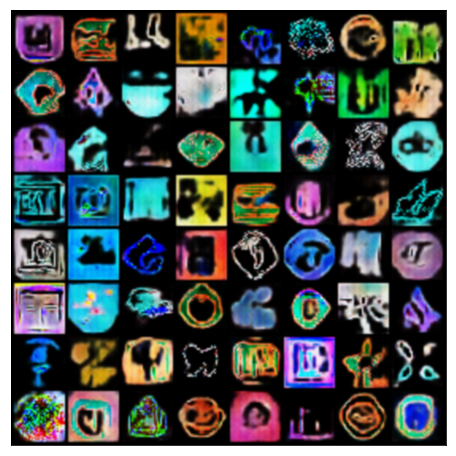

In [0]:
#manully plot
samples = G(fixed_noise, lb).detach()
showImages(samples[0:64])

### Training

In [ ]:
#apply initialize weights
G.apply(weights_init)
D.apply(weights_init)
applied = 1

In [0]:
Load_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
Load_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
Save_G_weightsPath = os.path.join(document,          "G_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
Save_D_weightsPath = os.path.join(document,          "D_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")     
Loss_savePath =  os.path.join(document,           "Loss_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
Generated_savePath =  os.path.join(document, "Generated_SNG4CBN_SND4C_all_nz100gf64_Glr000065_Dlr00042_L94_03_Noise10_16_cond100_CatBeforeFirstLayer")
print(applied)

if applied != 1:
  
  
    stateG_icon32x32=torch.load(Load_G_weightsPath)
    G.load_state_dict(stateG_icon32x32['state_dict'])
    optimizerG.load_state_dict(stateG_icon32x32['optimizer'])
    epoch_last = stateG_icon32x32['epoch']
    G_losses = stateG_icon32x32["G_losses"]
       
    stateD_icon32x32=torch.load(Load_D_weightsPath)
    D.load_state_dict(stateD_icon32x32['state_dict'])
    optimizerD.load_state_dict(stateD_icon32x32['optimizer'])
    D_losses = stateD_icon32x32["D_losses"]
    num_epochs =num_epochs- epoch_last
    
for epoch in range(num_epochs):
    # For each batch in the dataloader
    
    '''
    change training cluster here
    LLDloader
    '''
    running_lossG=[]
    running_lossD=[]
    for i, data in enumerate(LLDloader_cond, 0):
        X, cond = data

        '''
        ###########################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        '''
  
        '''
        ## Train with all-real batch
        '''
        # Firstly, have to set grad to zero
        
        ## Format batch

        real_img = X.to(device) 
        #add noise to stablize the training of gan
        real_img = real_img+torch.randn(real_img.size()).to(device)*0.1
        # Set the batch size same as the image batch size we input every time
        #sometimes it would not be same as the setting at original e.g.64, 60000/64 will left 32)
        b_size = real_img.size(0)

        ### label for conditional DCGAN ###
        # Create the label for images from true dataset   
        one_label = torch.full((b_size,), real_label).to(device) 
        zero_label = torch.full((b_size,), fake_label).to(device)
        noise = torch.randn(b_size, nz, 1, 1).to(device)

        #create onehot conditional label for G, it is a 100 vector
        cond_onehot = onehot(cond, b_size).to(device)
        #create onehot conditional label for D, it is a [batch_size 100 32 32] tensor
        cond_filled = filled[cond].to(device)
        ######################################
        
        D.zero_grad()
        G.zero_grad()
        # Forward pass real batch through D & G
        D_real = D(real_img, cond_filled).view(-1).to(device) 
        fake = G(noise, cond_onehot)
        fake = fake+torch.randn(fake.size()).to(device)*0.16
        D_fake = D(fake, cond_filled).view(-1).to(device)                                                   

        # Calculate loss on all-real batch
        D_loss_real = criterion(D_real, one_label)
        D_loss_fake = criterion(D_fake, zero_label)
        D_loss = D_loss_real + D_loss_fake                                                  
        # Calculate gradients for D in backward pass
        D_loss.backward()                                                            
        optimizerD.step()
                                                          
                                                          

       

        '''
        ###########################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        '''


        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = torch.randn(b_size, nz, 1, 1).to(device)
        fake = G(noise, cond_onehot)
        fake = fake+torch.randn(fake.size()).to(device)*0.16
        D_fake = D(fake,cond_filled).view(-1).to(device)                                                   

        # Calculate G's loss based on this output
        G_loss = criterion(D_fake, one_label)
        # Calculate gradients for G
        G_loss.backward()
        optimizerG.step()
                                                          
                                                          
        ########### for statistics ############
        D_Gz = D_fake.mean().item()
        D_x = D_real.mean().item()                                                  
        #######################################
        
        
        
        
        
        '''
        change training cluster here
        '''

        if i % 5000 == 0:
            print('[%d/%d][%d/%d]\t\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)):%.4f'
                  % (epoch, num_epochs, i, len(LLDloader_cond),
                     D_loss.item(), G_loss.item(), D_x, D_Gz))
            running_lossG.append(G_loss.item())
            running_lossD.append(D_loss.item())

    if epoch % 1==0:
        # Save Losses for plotting later
        G_losses.append(np.mean(running_lossG))
        D_losses.append(np.mean(running_lossD))
        
        
        
    if epoch % 1==0:



        stateG_icon32x32 = {
            'epoch': epoch,
            'state_dict': G.state_dict(),
            'optimizer': optimizerG.state_dict(),
            'G_losses': G_losses,
        }
        torch.save(stateG_icon32x32, Save_G_weightsPath) 


        stateD_icon32x32 = {
            'epoch': epoch,
            'state_dict': D.state_dict(),
            'optimizer': optimizerD.state_dict(),
            'D_losses': D_losses,
        }
        torch.save(stateD_icon32x32, Save_D_weightsPath)

        print("saved successfully")

        
    if epoch % 1==0:
      
        samples = G(fixed_noise, fixed_cond).detach()        
        showImages(samples[0:8])
        

font = {
        'color':  'blue',
     
        'size': 16,
        }

plt.figure()    
plt.plot(G_losses,label = "Loss of G")
plt.plot(D_losses,label = "Loss of D")
plt.legend(loc="best")
plt.title("Loss of D and G after %.0f epochs" % (epoch),fontdict=font)
plt.xlabel('Number of Epochs',fontdict=font)
plt.ylabel('Loss',fontdict=font)
plt.savefig(Loss_savePath)
plt.show()


samples = G(fixed_noise, fixed_cond).detach()
saveImages(samples[0:64],Generated_savePath)

0
[0/48][0/11059]		Loss_D: 0.5233	Loss_G: 1.9209	D(x): 0.8199	D(G(z)):0.1335


KeyboardInterrupt: ignored